In [1]:
import importlib
from pathlib import Path

import kMC_sequence_design_pytorch as kmc
import logomaker as lm
import matplotlib as mpl
import models
import numpy as np
import pandas as pd
import predict_pytorch
import pyBigWig
import seaborn as sns
import shap
import torch
import train_pytorch
import utils
from Bio import SeqIO
from kMC_sequence_design_pytorch import get_profile_torch
from matplotlib import pyplot as plt

# import scipy
# from scipy.stats import pearsonr

prop_cycle = plt.rcParams["axes.prop_cycle"]
colors = prop_cycle.by_key()["color"]
# sns.set_theme()

/home/alex/miniconda3/envs/flamingo-3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
# device = "cpu"
print(f"Using {device} device")
model_nuc = models.BassenjiMultiNetwork2(n_tracks=1).to(device)
model_nuc_file = "Trainedmodels/model_myco_nuc_pt8/model_state.pt"
model_nuc.load_state_dict(torch.load(model_nuc_file))
model_nuc.eval()

model_nuc2 = models.BassenjiMultiNetwork2(n_tracks=1).to(device)
model_nuc_file2 = "Trainedmodels/model_myco_nuc_pt17/model_state.pt"
model_nuc2.load_state_dict(torch.load(model_nuc_file2))
model_nuc2.eval()

model_pol = models.BassenjiMultiNetwork2(n_tracks=1).to(device)
model_pol_file = "Trainedmodels/model_myco_pol_pt8/model_state.pt"
model_pol.load_state_dict(torch.load(model_pol_file))
model_pol.eval()

model_nucpol = models.BassenjiMultiNetwork2(n_tracks=2).to(device)
model_nucpol_file = "Trainedmodels/model_myco_nucpol_pt8/model_state.pt"
model_nucpol.load_state_dict(torch.load(model_nucpol_file))
model_nucpol.eval()

Using cuda device


BassenjiMultiNetwork2(
  (conv_stack): Sequential(
    (0): PooledConvLayer(
      (pooled_conv): Sequential(
        (0): Conv1d(4, 64, kernel_size=(12,), stride=(1,), padding=same)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
        (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (1): PooledConvLayer(
      (pooled_conv): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
        (1): ReLU()
        (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.2, inplace=False)
      )
    )
    (2): PooledConvLayer(
      (pooled_conv): Sequential(
        (0): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=same)
        (1): ReLU()
        (2): MaxP

In [7]:
dataset = train_pytorch.SequenceDatasetRAM(
    seq_file="/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa",
    label_files=["/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.bw"],
    chroms=["chrXVI"],
    winsize=2048,
    head_interval=16,
)

In [4]:
from typing import List, Union


def string_to_char_array(seq):
    """
    Converts an ASCII string to a NumPy array of byte-long ASCII codes.
    e.g. "ACGT" becomes [65, 67, 71, 84].
    From github.com/kundajelab/deeplift/blob/master/deeplift/dinuc_shuffle.py
    """
    return np.frombuffer(bytearray(seq, "utf8"), dtype=np.int8)


def char_array_to_string(arr):
    """
    Converts a NumPy array of byte-long ASCII codes into an ASCII string.
    e.g. [65, 67, 71, 84] becomes "ACGT".
    From github.com/kundajelab/deeplift/blob/master/deeplift/dinuc_shuffle.py
    """
    return arr.tostring().decode("ascii")


def one_hot_to_tokens(one_hot):
    """
    Converts an L x D one-hot encoding into an L-vector of integers in the
    range [0, D], where the token D is used when the one-hot encoding is all 0.
    This assumes that the one-hot encoding is well-formed, with at most one 1
    in each column (and 0s elsewhere).
    From github.com/kundajelab/deeplift/blob/master/deeplift/dinuc_shuffle.py
    """
    # Vector of all D
    tokens = np.full(one_hot.shape[0], one_hot.shape[1], dtype=int)
    seq_inds, dim_inds = np.where(one_hot)
    tokens[seq_inds] = dim_inds
    return tokens


def tokens_to_one_hot(tokens, one_hot_dim, dtype=None):
    """
    Converts an L-vector of integers in the range [0, D] to an L x D one-hot
    encoding. The value `D` must be provided as `one_hot_dim`. A token of D
    means the one-hot encoding is all 0s.
    From github.com/kundajelab/deeplift/blob/master/deeplift/dinuc_shuffle.py
    """
    identity = np.identity(one_hot_dim + 1, dtype=dtype)[:, :-1]  # Last row is all 0s
    return identity[tokens]


def dinuc_shuffle(
    seq: Union[str, np.ndarray],
    num_shufs: int = None,
    rng: np.random.Generator = np.random.default_rng(),
) -> Union[str, List[str], np.ndarray]:
    """
    Creates shuffles of the given sequence, in which dinucleotide frequencies
    are preserved.
    Arguments:
        `seq`: either a string of length L, or an L x D NumPy array of one-hot
            encodings
        `num_shufs`: the number of shuffles to create, N; if unspecified, only
            one shuffle will be created
        `rng`: a NumPy RandomState object, to use for performing shuffles
    If `seq` is a string, returns a list of N strings of length L, each one
    being a shuffled version of `seq`. If `seq` is a 2D NumPy array, then the
    result is an N x L x D NumPy array of shuffled versions of `seq`, also
    one-hot encoded. If `num_shufs` is not specified, then the first dimension
    of N will not be present (i.e. a single string will be returned, or an
    L x D array).
    From github.com/kundajelab/deeplift/blob/master/deeplift/dinuc_shuffle.py
    """
    if isinstance(seq, str):
        arr = string_to_char_array(seq)
    elif type(seq) is np.ndarray and len(seq.shape) == 2:
        seq_len, one_hot_dim = seq.shape
        arr = one_hot_to_tokens(seq)
    else:
        raise ValueError("Expected string or one-hot encoded array")

    # Get the set of all characters, and a mapping of which positions have
    # which characters; use `tokens`, which are integer representations of the
    # original characters
    chars, tokens = np.unique(arr, return_inverse=True)

    # For each token, get a list of indices of all the tokens that come after
    # it
    shuf_next_inds = []
    for t in range(len(chars)):
        mask = tokens[:-1] == t  # Excluding last char
        inds = np.where(mask)[0]
        shuf_next_inds.append(inds + 1)  # Add 1 for next token

    if isinstance(seq, str):
        all_results = []
    else:
        all_results = np.empty(
            (num_shufs if num_shufs else 1, seq_len, one_hot_dim), dtype=seq.dtype
        )

    for i in range(num_shufs if num_shufs else 1):
        # Shuffle the next indices
        for t in range(len(chars)):
            inds = np.arange(len(shuf_next_inds[t]))
            inds[:-1] = rng.permutation(len(inds) - 1)  # Keep last index same
            shuf_next_inds[t] = shuf_next_inds[t][inds]

        counters = [0] * len(chars)

        # Build the resulting array
        ind = 0
        result = np.empty_like(tokens)
        result[0] = tokens[ind]
        for j in range(1, len(tokens)):
            t = tokens[ind]
            ind = shuf_next_inds[t][counters[t]]
            counters[t] += 1
            result[j] = tokens[ind]

        if isinstance(seq, str):
            all_results.append(char_array_to_string(chars[result]))
        else:
            all_results[i] = tokens_to_one_hot(chars[result], one_hot_dim)
    return all_results if num_shufs else all_results[0]

In [5]:
def torch_dinuc_shuffle(
    tensor: torch.Tensor,
    num_shufs: int,
    rng: np.random.Generator = np.random.default_rng(),
) -> torch.Tensor:
    array = tensor.detach().cpu().numpy()
    shuffles = dinuc_shuffle(array, num_shufs, rng)
    return torch.tensor(shuffles)

In [8]:
data = []
for i in range(0, len(dataset), 2048):
    data.append(dataset[i][0])
data = torch.tensor(np.stack(data, axis=0)).to(device)
data.shape

torch.Size([446, 2048, 4])

In [31]:
# select minimal amount of windows that overlap all possible bases
last_saved_pos = -1
prev_pos = -1
saved_pos = []
for i, (_, pos) in enumerate(dataset.positions):
    if pos - last_saved_pos == 2048 or last_saved_pos == -1:
        saved_pos.append((i, pos))
        last_saved_pos = pos
    elif pos - last_saved_pos > 2048 and prev_pos != last_saved_pos:
        saved_pos.append((i - 1, prev_pos))
        last_saved_pos = prev_pos
    prev_pos = pos
print(len(saved_pos))

449


In [9]:
SHAP = shap.DeepExplainer(model_nuc, data)

/home/alex/miniconda3/envs/flamingo-3.10/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


In [10]:
from typing import Tuple

from torch.utils.data import DataLoader


def get_shap_values(
    explainer: shap.explainers._deep.DeepExplainer,
    seq: np.ndarray,
    winsize: int,
    head_interval: int,
    head_crop: int = 0,
    n_tracks: int = 1,
    reverse: bool = False,
    stride: int = 1,
    offset: int = 0,
    jump_stride: int = None,
    kept_heads_start: int = None,
    batch_size: int = 1024,
    num_workers: int = 4,
    verbose: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    pred_dataset = predict_pytorch.PredSequenceDatasetRAM(
        seq,
        winsize,
        head_interval,
        head_crop=head_crop,
        n_tracks=n_tracks,
        reverse=reverse,
        stride=stride,
        offset=offset,
        jump_stride=jump_stride,
    )
    pred_dataloader = DataLoader(
        pred_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers
    )
    res = []
    size = len(pred_dataset)
    for batch, X in enumerate(pred_dataloader):
        X = X.to(next(explainer.model.parameters()).device)
        res.append(explainer.shap_values(X, check_additivity=False))
        if verbose and batch % 100 == 0:
            print(f"{(batch+1)*len(X)}/{size}")
    res = np.concatenate(res, axis=0)
    return res, pred_dataset.positions
    # return pred_dataset.reshaper(res, kept_heads_start), pred_dataset.get_indices(
    #     kept_heads_start
    # )

In [ ]:
from Bio import SeqIO

seq_dict = utils.ordinal_encoder(
    {
        res.id: res.seq
        for res in SeqIO.parse(
            "/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa", "fasta"
        )
        if res.id in ["chrXVI"]
    }
)
res, positions = get_shap_values(
    SHAP,
    seq_dict["chrXVI"][:5_000],
    winsize=2048,
    head_interval=16,
    stride=16,
    jump_stride=1024,
)

In [3]:
with np.load("shap/shap_model_myco_nuc_pt8_on_W303_Mmmyco_mid_chrI_for.npz") as f:
    positions = f["positions"]
    res = f["res"]

In [4]:
seq_dict = utils.ordinal_encoder(
    {
        res.id: res.seq
        for res in SeqIO.parse(
            "/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa", "fasta"
        )
        if res.id in ["chrI"]
    }
)
one_hot = utils.idx_to_onehot(seq_dict["chrI"])

In [27]:
with pyBigWig.open(
    "Trainedmodels/model_myco_nuc_pt8/preds_model_myco_nuc_pt8_on_W303_Mmmyco_mid_track0.bw"
) as bw:
    preds = bw.values("chrI_for", 0, -1, numpy=True)
with np.load("/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz") as f:
    labels = f["chrI"]

In [6]:
with np.load(
    "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_model_myco_nuc_2_W303_Mmmyco_onseq_sumabs.npz"
) as f:
    saliency_ref = f["chrI"]

In [26]:
contrib_sum = []
aligned_contrib_sum = np.zeros(len(one_hot))
aligned_contrib_sum_partial = np.zeros(len(one_hot))
for i, pos in enumerate(positions):
    contrib_sum.append(
        np.abs(res[i] * np.expand_dims(one_hot[pos : pos + 2048], axis=-1))
        .sum(axis=1)[:, 32:96]
        .sum(axis=1)
    )
    aligned_contrib_sum[pos : pos + 2048] += contrib_sum[i]
    if i % 16 == 0:
        aligned_contrib_sum_partial[pos : pos + 2048] += contrib_sum[i]
contrib_sum = np.array(contrib_sum)
contrib_sum.shape, aligned_contrib_sum.shape

((3824, 2048), (245675,))

In [48]:
z_score_full = utils.z_score(aligned_contrib_sum)
z_score_partial = utils.z_score(aligned_contrib_sum_partial)
diffs = z_score_full - z_score_partial

In [50]:
(z_score_full > 4).sum()

1581

In [51]:
(z_score_partial > 4).sum()

1545

In [37]:
(diff_locs,) = (np.abs(diffs) > 1).nonzero()
diff_locs

array([   665,    672,    676, ..., 241974, 245134, 245235])

In [46]:
diff_locs[diff_locs > 1650]

array([  2593,   2674,   2682, ..., 241974, 245134, 245235])

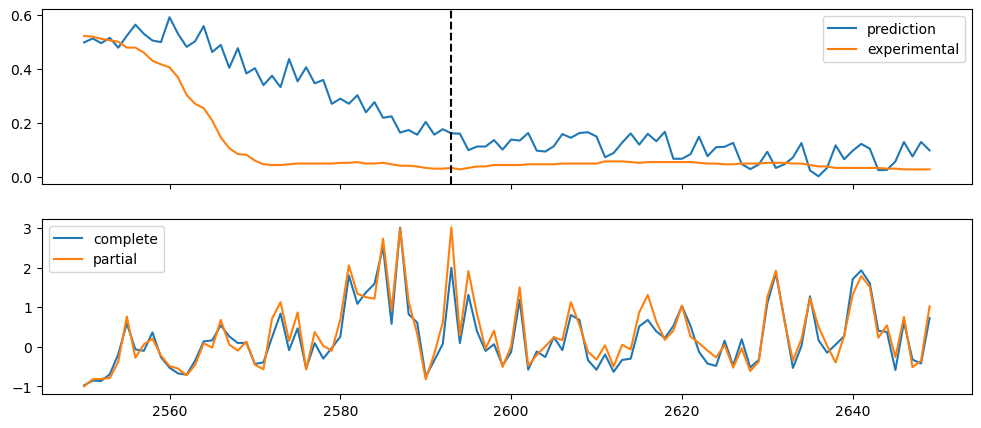

In [47]:
start = 2550
stop = start + 100
fig, axes = plt.subplots(2, 1, figsize=(12, 5), facecolor="w", sharex=True)
axes[0].plot(np.arange(start, stop), preds[start:stop], label="prediction")
axes[0].plot(np.arange(start, stop), labels[start:stop], label="experimental")
axes[1].plot(
    np.arange(start, stop), z_score(aligned_contrib_sum)[start:stop], label="complete"
)
axes[1].plot(
    np.arange(start, stop),
    z_score(aligned_contrib_sum_partial)[start:stop],
    label="partial",
)
for loc in diff_locs[(diff_locs >= start) & (diff_locs < stop)]:
    axes[0].axvline(loc, color="k", linestyle="--")
for ax in axes:
    ax.legend()

{'whiskers': [<matplotlib.lines.Line2D at 0x772812e47160>,
 'caps': [<matplotlib.lines.Line2D at 0x772812e476a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x772812c6ada0>],
 'medians': [<matplotlib.lines.Line2D at 0x772812e47be0>],
 'fliers': [<matplotlib.lines.Line2D at 0x772812e47e80>],
 'means': []}

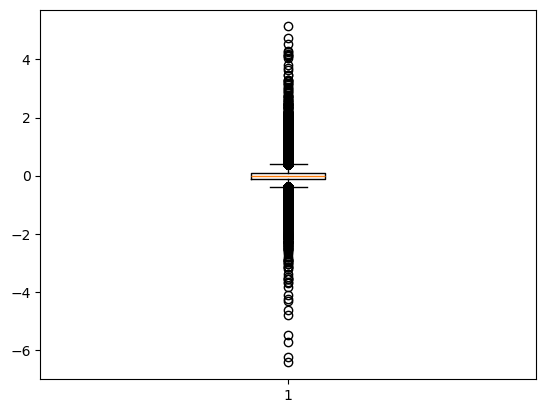

In [32]:
plt.boxplot(diffs)

<Axes: >

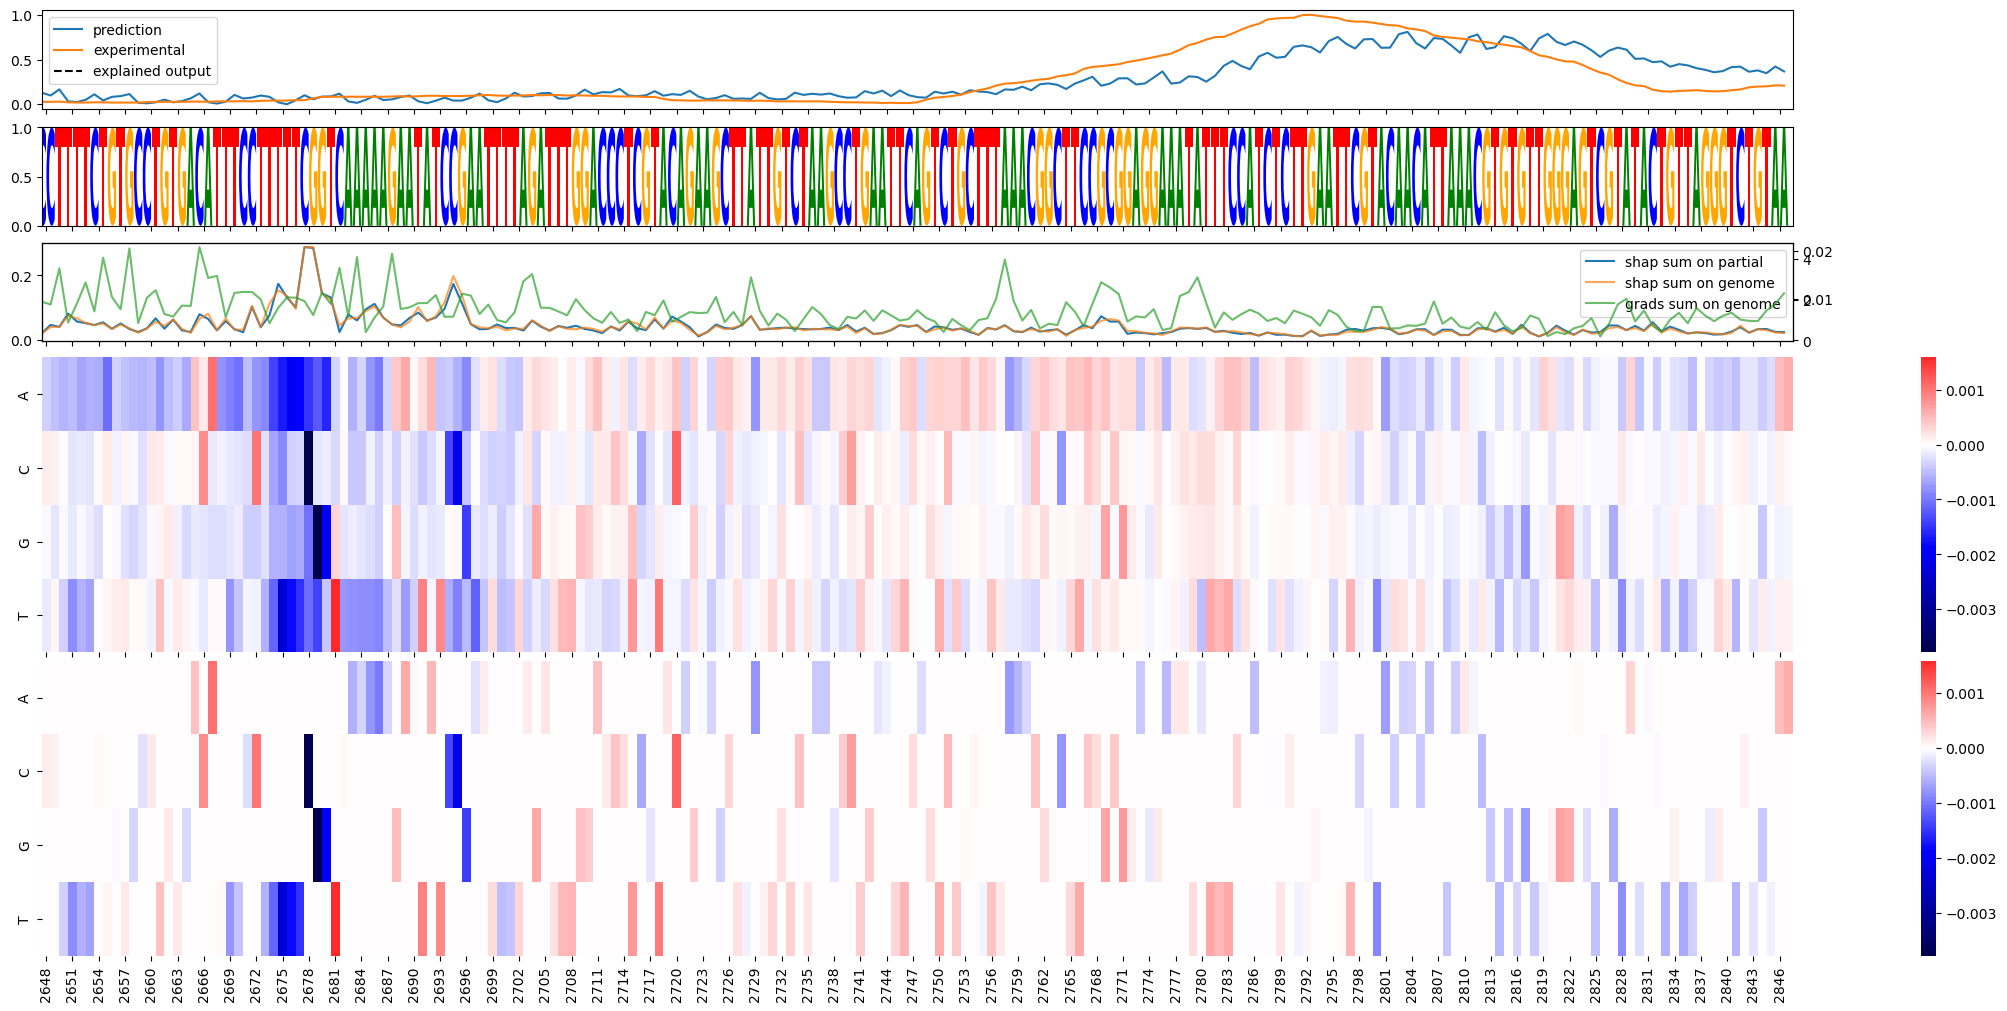

In [53]:
idx = 32
pred_idx = 64
start = 600  # 0
stop = 800  # 2048
pos = positions[idx]
X = one_hot[pos + start : pos + stop]
# modstart = start // 16
# modstop = stop // 16
fig, axes = plt.subplots(
    5,
    1,
    figsize=(20, 10),
    facecolor="w",
    layout="constrained",
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1, 1, 3, 3]},
)
axes[0].plot(preds[pos + start : pos + stop], label="prediction")
axes[0].plot(labels[pos + start : pos + stop], label="experimental")
axes[0].axvline(
    x=pred_idx * 16 - start, color="k", linestyle="--", label="explained output"
)
axes[0].legend()
if stop - start < 1000:
    lm.Logo(
        pd.DataFrame(X, columns=list("ACGT"), index=np.arange(stop - start)),
        ax=axes[1],
    )
# compute sum of absolute contributions for all outputs
# axes[2].plot(contrib_sum[idx, start:stop], label="shap sum on window")
axes[2].plot(
    aligned_contrib_sum_partial[pos + start : pos + stop], label="shap sum on partial"
)
axsup = axes[2].twinx()
axsup.plot(
    aligned_contrib_sum[pos + start : pos + stop],
    color=colors[1],
    alpha=0.7,
    label="shap sum on genome",
)
axsup2 = axes[2].twinx()
axsup2.plot(
    saliency_ref[pos + start : pos + stop],
    color=colors[2],
    alpha=0.7,
    label="grads sum on genome",
)
axes[2].legend(*utils.get_legend([axes[2], axsup, axsup2]))
# show full contributions for pred_idx
resdf = pd.DataFrame(
    res[idx, start:stop, :, pred_idx].T,
    index=list("ACGT"),
    columns=np.arange(pos + start, pos + stop),
)
sns.heatmap(resdf, cmap="seismic", center=0, ax=axes[-2])
# show only actual sequence contribution for pred_idx
sns.heatmap(resdf * X.T, cmap="seismic", center=0, ax=axes[-1])

In [74]:
layer2 = list(model_nuc.parameters())[1].detach().cpu()
layer2.shape

torch.Size([64])

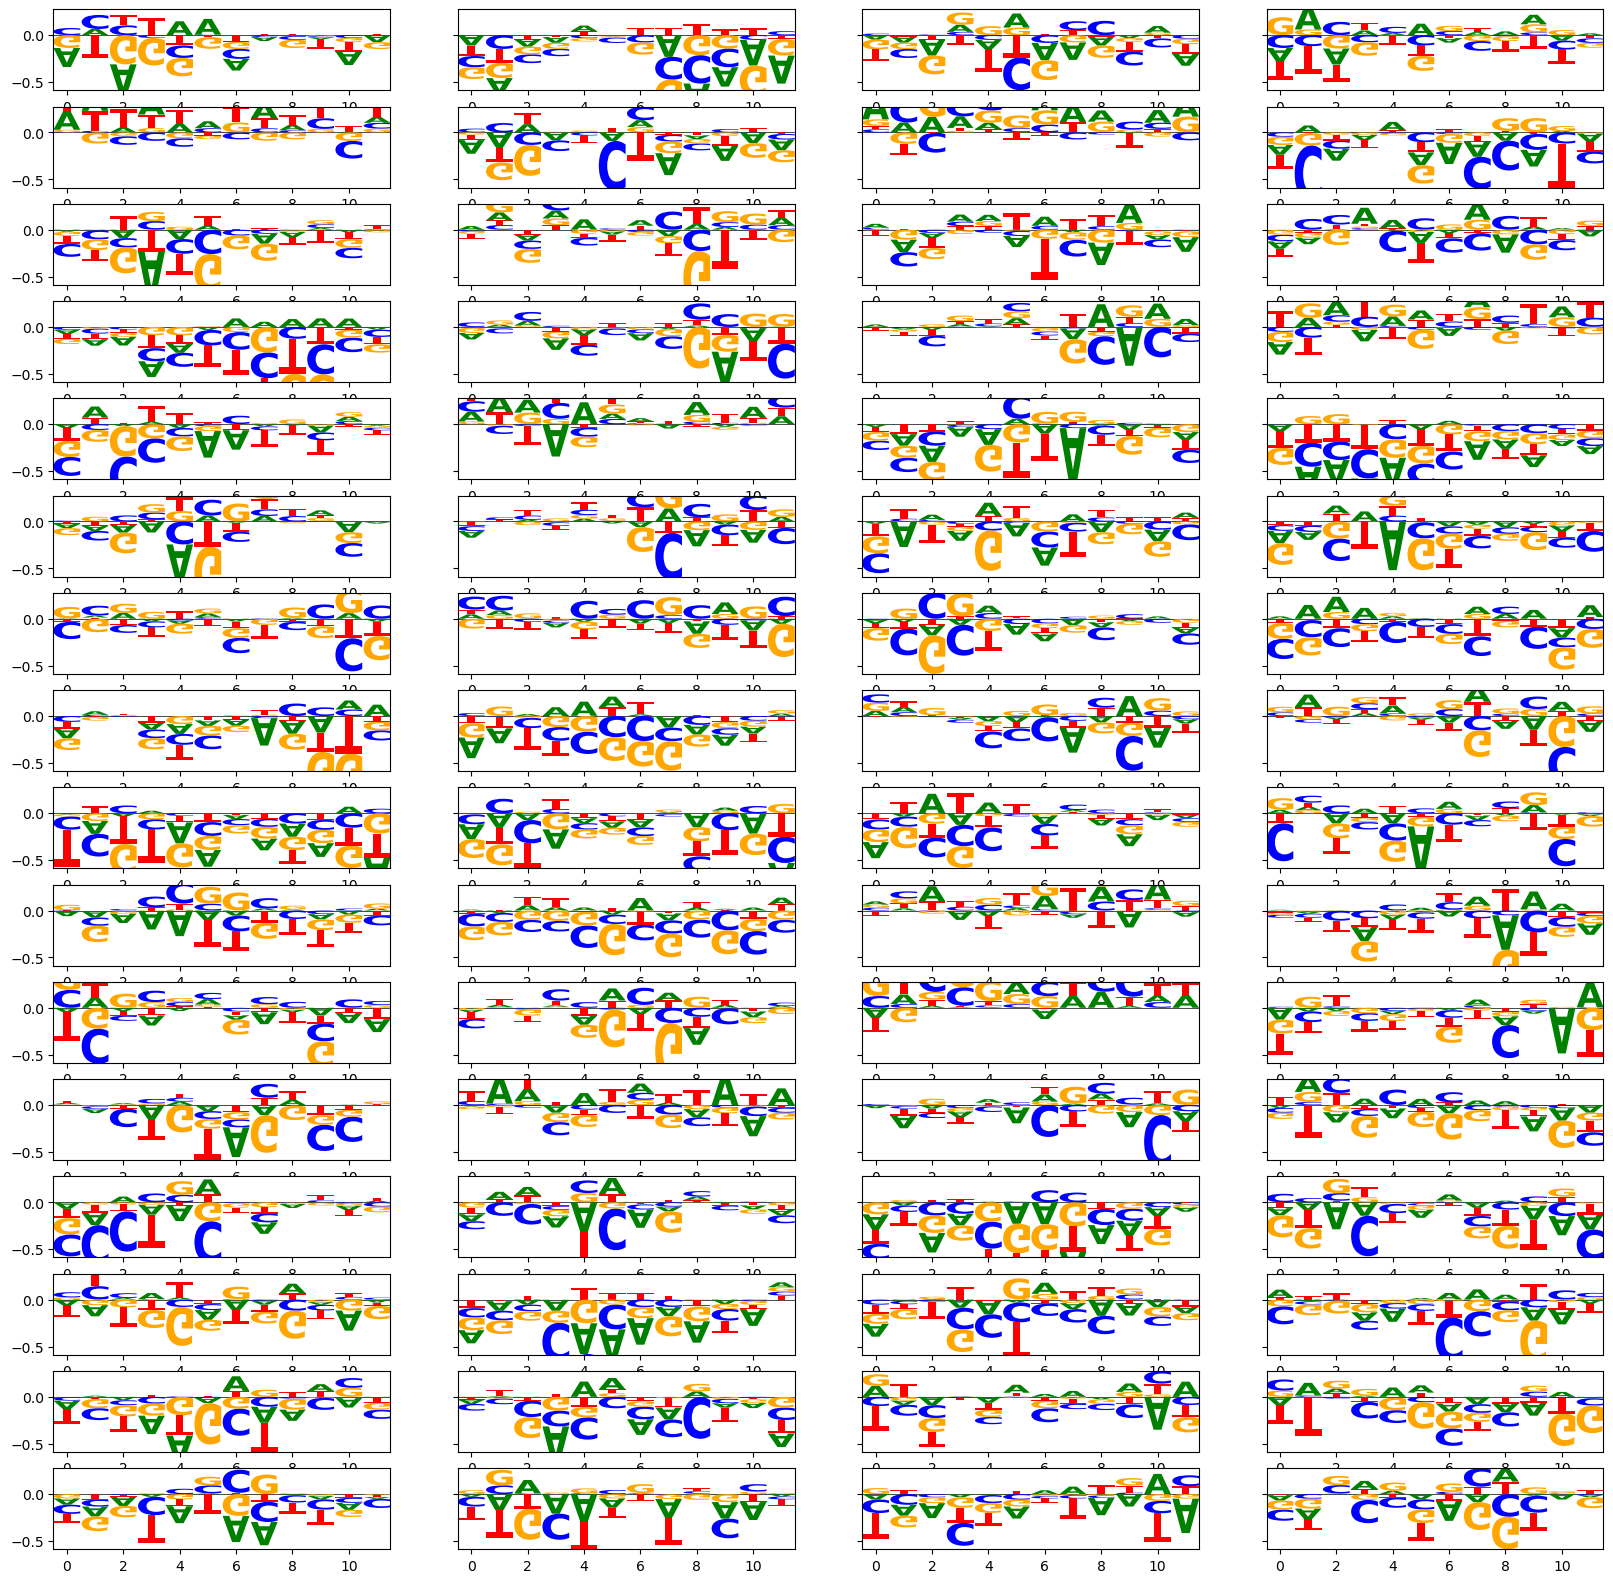

In [76]:
layer1 = next(model_nuc.parameters()).detach().cpu()
fig, axes = plt.subplots(16, 4, figsize=(20, 20), facecolor="w", sharey=True)
for i, ax in enumerate(axes.flatten()):
    lm.Logo(
        pd.DataFrame(
            layer1[i].T + layer2[i] / 4, index=np.arange(12), columns=list("ACGT")
        ),
        ax=ax,
    )

In [7]:
idx = 25_000
pos = dataset.positions[idx][1]
X, y, w = dataset[idx]
pos, y.mean(), w.sum()

(34643, 0.27229422, 128)

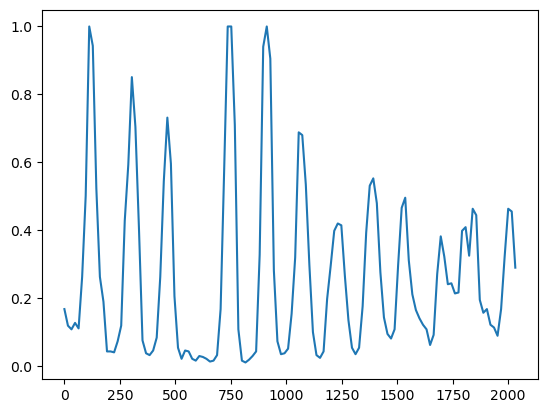

In [8]:
plt.plot(np.arange(0, 2048, 16), y)
# offset = -16 * 8
# plt.plot(np.arange(offset, 2048 + offset, 16), dataset[idx + offset][1])

In [79]:
for i in range(0, len(dataset), 2048):
    _, y, _ = dataset[i]
    print(i, np.sum(y != 0))
    if np.sum(y != 0) > 64:
        break

0 1
2048 92


In [58]:
res_full = SHAP.shap_values(data[:10], check_additivity=False)

In [45]:
res_solo = SHAP.shap_values(data[:1])

In [62]:
dataset.positions[::2048][:10]

[(0, 9643),
 (0, 11691),
 (0, 13739),
 (0, 15787),
 (0, 17835),
 (0, 19883),
 (0, 21931),
 (0, 23979),
 (0, 26027),
 (0, 28075)]

In [60]:
res_full.shape, res_solo.shape

((10, 2048, 4, 128), (1, 2048, 4, 128))

In [61]:
np.allclose(res_full[0], res_solo[0])

True

<Axes: >

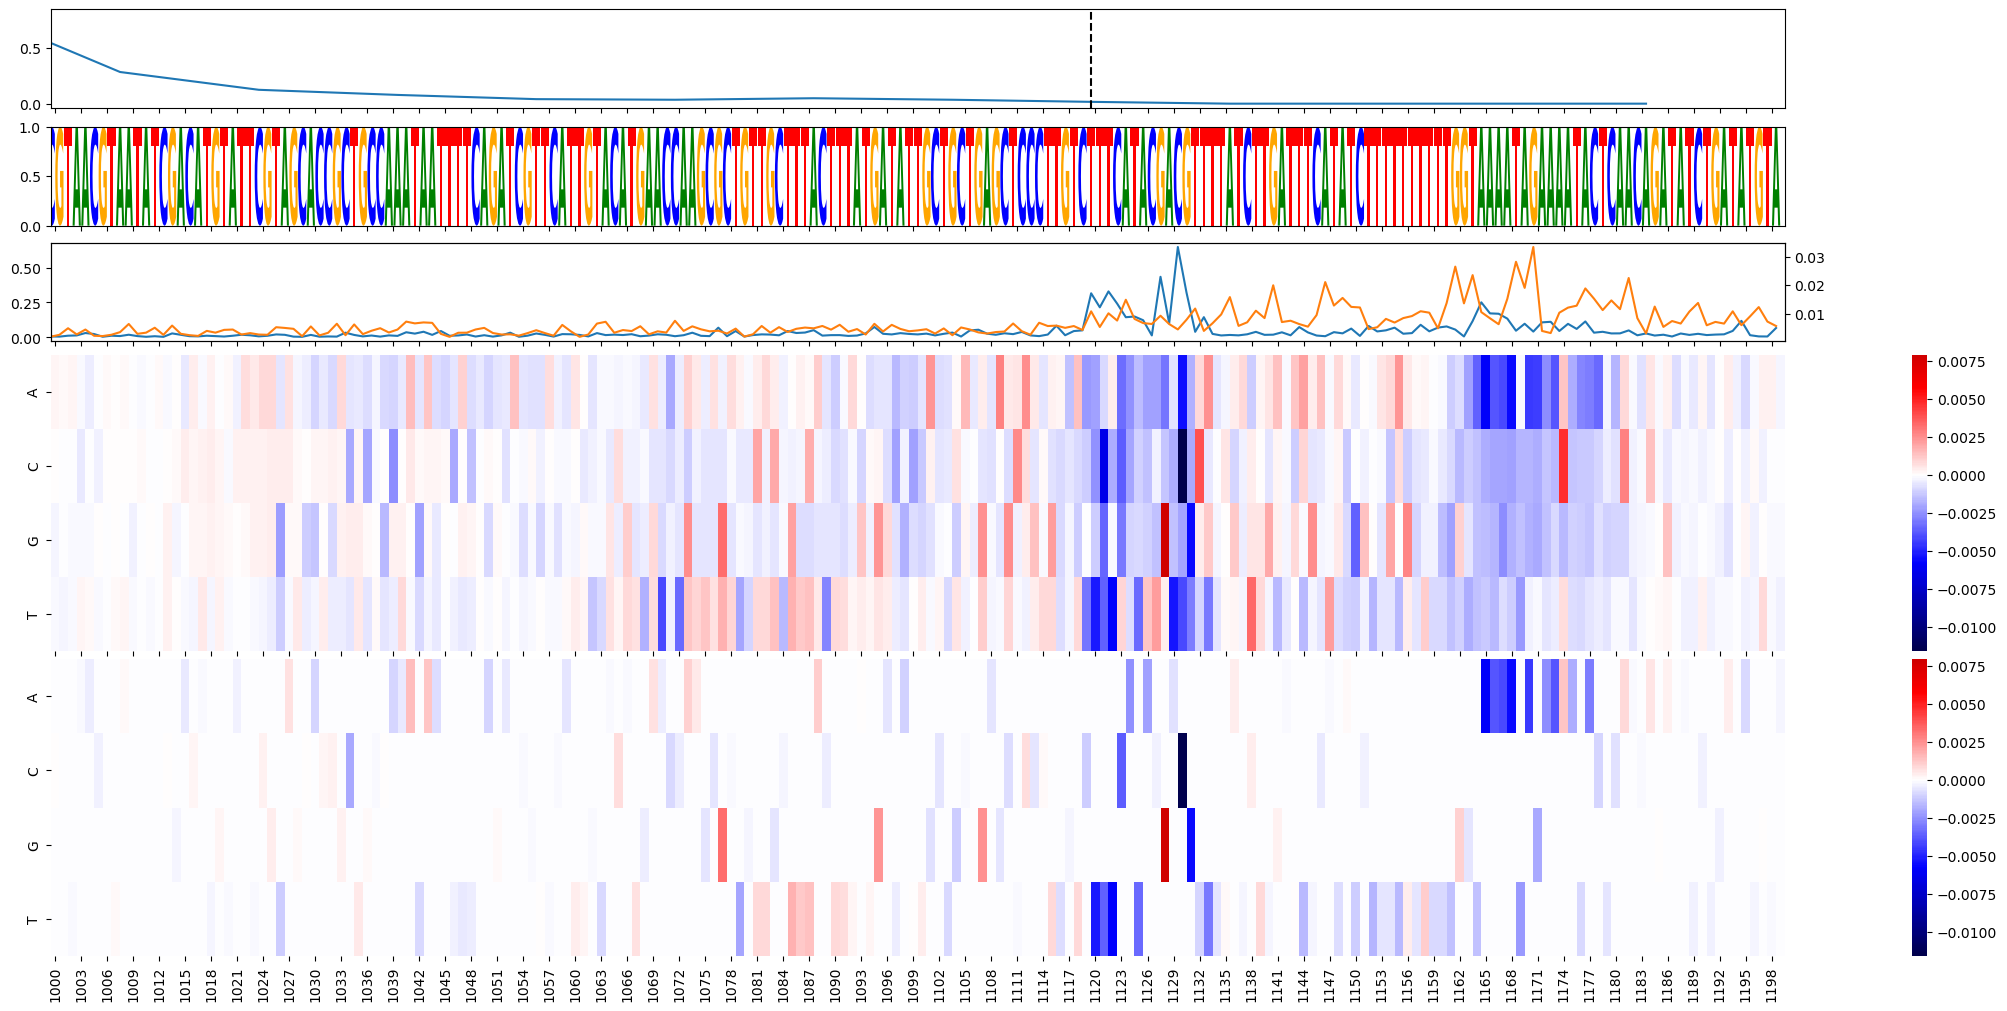

In [87]:
dataset_idx = 2
pos = dataset.positions[dataset_idx * 2084][1]
X, y, z = dataset[dataset_idx * 2084]
pred_idx = 70
start = 1000  # 0
stop = 1200  # 2048
modstart = start // 16
modstop = stop // 16
fig, axes = plt.subplots(
    5,
    1,
    figsize=(20, 10),
    facecolor="w",
    layout="constrained",
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1, 1, 3, 3]},
)
axes[0].plot(np.arange(16 * modstart, 16 * modstop, 16) - start, y[modstart:modstop])
axes[0].axvline(x=pred_idx * 16 - start, color="k", linestyle="--")
if stop - start < 1000:
    lm.Logo(
        pd.DataFrame(
            X[start:stop], columns=list("ACGT"), index=np.arange(stop - start)
        ),
        ax=axes[1],
    )
# compute sum of absolute contributions for all outputs
contrib_sum = (
    np.abs(res_full[dataset_idx] * np.expand_dims(X, axis=-1)).sum(axis=1).sum(axis=1)
)
axes[2].plot(contrib_sum[start:stop])
axsup = axes[2].twinx()
axsup.plot(saliency_ref[pos + start : pos + stop], color=colors[1])
# show full contributions for pred_idx
resdf = pd.DataFrame(
    res_full[dataset_idx, start:stop, :, pred_idx].T,
    index=list("ACGT"),
    columns=np.arange(start, stop),
)
sns.heatmap(resdf, cmap="seismic", center=0, ax=axes[-2])
# show only actual sequence contribution for pred_idx
sns.heatmap(resdf * X[start:stop].T, cmap="seismic", center=0, ax=axes[-1])

In [9]:
res = SHAP.shap_values(torch.tensor(np.expand_dims(X, axis=0)))

In [63]:
with np.load(
    "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_model_myco_nuc_2_W303_Mmmyco_onseq_sumabs.npz"
) as f:
    saliency_ref = f["chrXVI"]

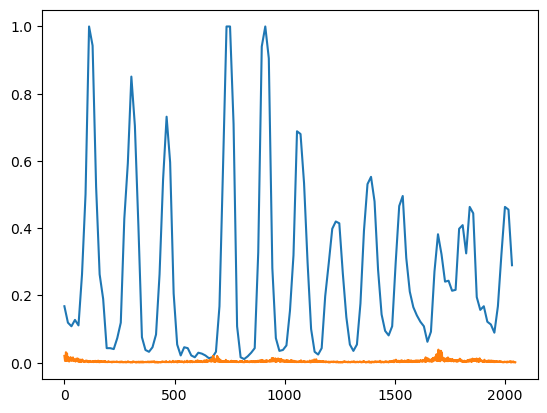

In [64]:
plt.plot(np.arange(0, 2048, 16), y)
plt.plot(saliency_ref[pos : pos + 2048])

<Axes: >

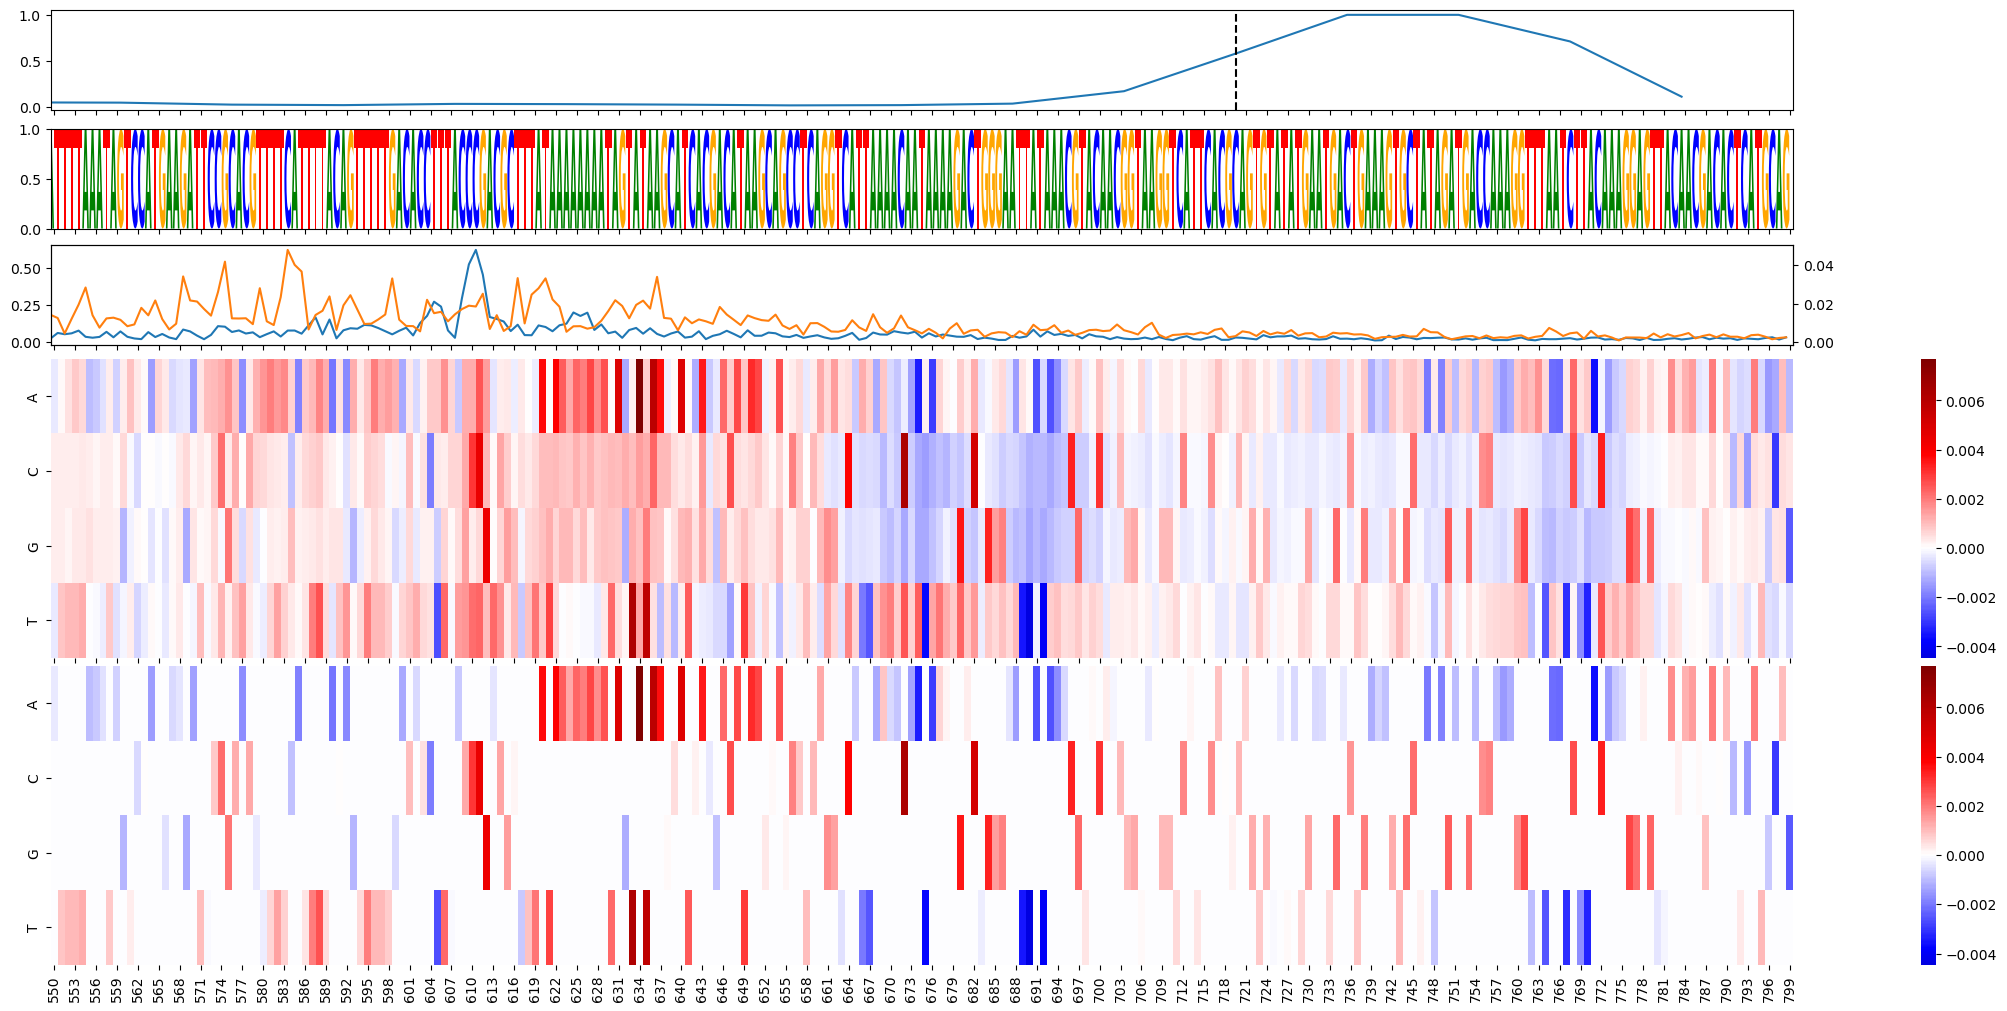

In [12]:
pred_idx = 45
start = 550
stop = 800  # 2001
modstart = start // 16
modstop = stop // 16
fig, axes = plt.subplots(
    5,
    1,
    figsize=(20, 10),
    facecolor="w",
    layout="constrained",
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1, 1, 3, 3]},
)
axes[0].plot(np.arange(16 * modstart, 16 * modstop, 16) - start, y[modstart:modstop])
axes[0].axvline(x=pred_idx * 16 - start, color="k", linestyle="--")
if stop - start < 1000:
    lm.Logo(
        pd.DataFrame(
            X[start:stop], columns=list("ACGT"), index=np.arange(stop - start)
        ),
        ax=axes[1],
    )
# compute sum of absolute contributions for all outputs
contrib_sum = np.abs(res[0] * np.expand_dims(X, axis=-1)).sum(axis=1).sum(axis=1)
axes[2].plot(contrib_sum[start:stop])
axsup = axes[2].twinx()
axsup.plot(saliency_ref[pos + start : pos + stop], color=colors[1])
# show full contributions for pred_idx
resdf = pd.DataFrame(
    res[0, start:stop, :, pred_idx].T,
    index=list("ACGT"),
    columns=np.arange(start, stop),
)
sns.heatmap(resdf, cmap="seismic", center=0, ax=axes[-2])
# show only actual sequence contribution for pred_idx
sns.heatmap(resdf * X[start:stop].T, cmap="seismic", center=0, ax=axes[-1])

<Axes: >

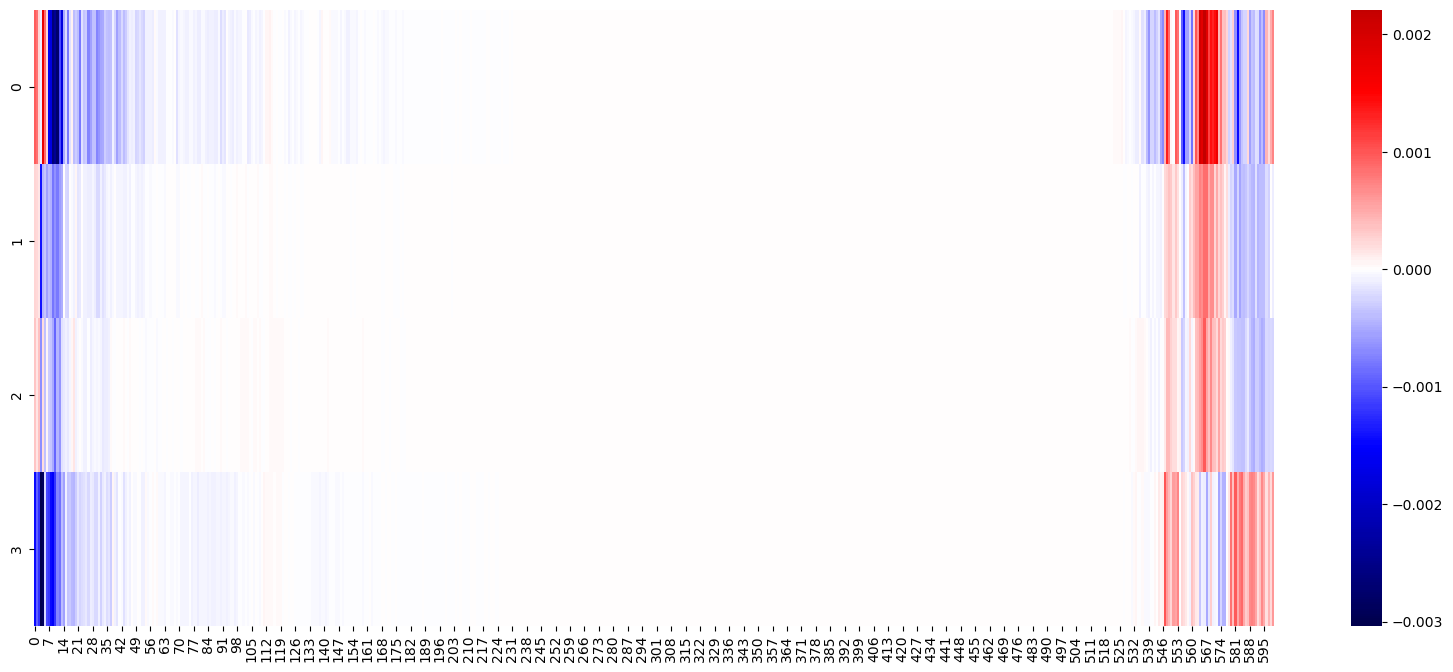

In [13]:
plt.subplots(1, 1, figsize=(20, 8))
sns.heatmap(
    np.transpose(res[0, (X.argmax(axis=1) == 0)], [1, 2, 0]).reshape(4, -1)[
        :, 16 * 600 : 17 * 600
    ],
    cmap="seismic",
    center=0,
)

In [15]:
np.transpose(res[0, (X.argmax(axis=1) == 0)], [2, 0, 1])[16].reshape(-1, 4).shape

(723, 4)

In [16]:
from scipy.cluster.hierarchy import linkage


array([[4.57000000e+02, 4.58000000e+02, 0.00000000e+00, 2.00000000e+00],
       [4.59000000e+02, 7.23000000e+02, 0.00000000e+00, 3.00000000e+00],
       [4.60000000e+02, 7.24000000e+02, 0.00000000e+00, 4.00000000e+00],
       ...,
       [1.43500000e+03, 1.43800000e+03, 5.25298780e-03, 6.47000000e+02],
       [1.44000000e+03, 1.44200000e+03, 8.82381946e-03, 6.71000000e+02],
       [1.44100000e+03, 1.44300000e+03, 9.42198899e-03, 7.23000000e+02]])

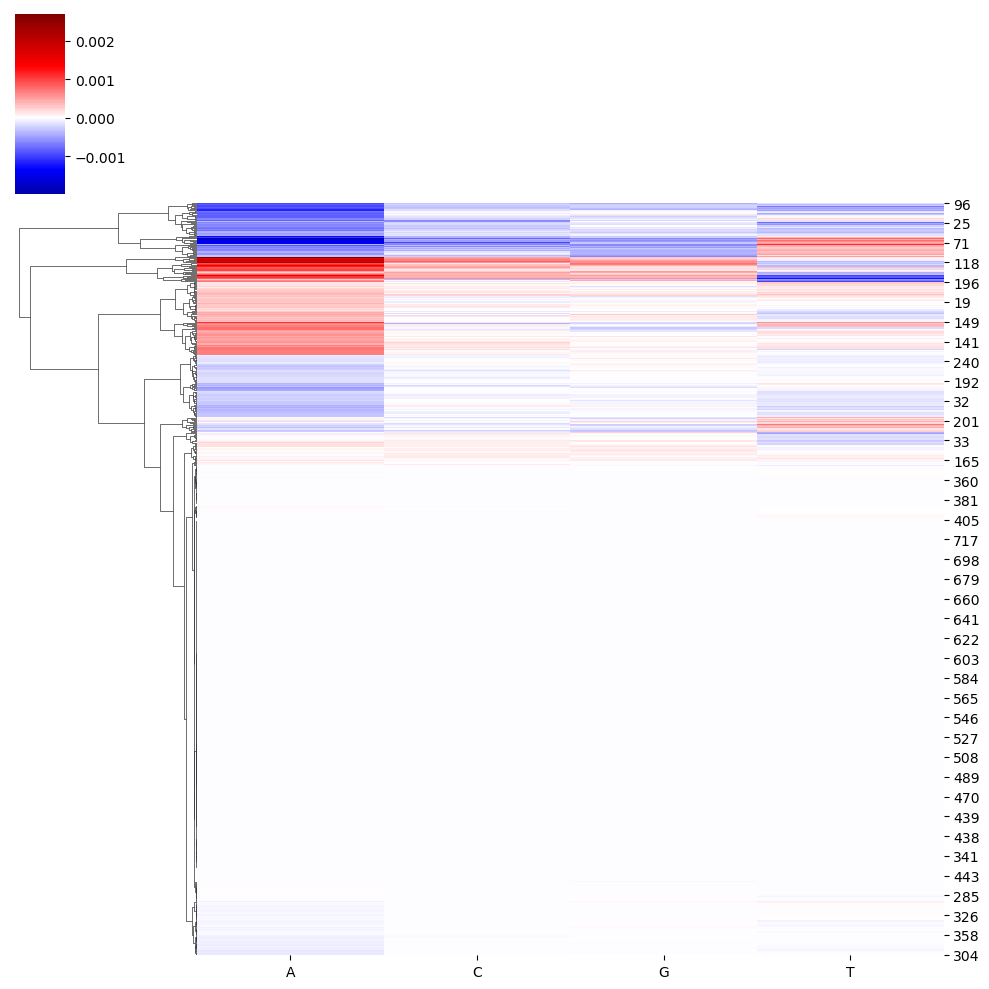

In [18]:
sns.clustermap(
    pd.DataFrame(heatmap_vals, columns=list("ACGT")),
    center=0,
    cmap="seismic",
    row_linkage=link_matrix,
    col_cluster=False,
    robust=False,
)

In [79]:
(res[0] * np.expand_dims(X, axis=-1)).sum(axis=1)

array([[3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 4, 4, 4],
       [3, 3, 3, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3],
       [4, 4, 4, ..., 3, 3, 3]])

In [ ]:
start = 0
stop = 300  # 2001
modstart = start // 16
modstop = stop // 16
fig, axes = plt.subplots(
    4,
    1,
    figsize=(20, 10),
    facecolor="w",
    layout="constrained",
    sharex=True,
    gridspec_kw={"height_ratios": [1, 1, 3, 3]},
)
axes[0].plot(np.arange(16 * modstart, 16 * modstop, 16), y[modstart:modstop])
axes[0].axvline(x=pred_idx * 16, color="k", linestyle="--")
lm.Logo(
    pd.DataFrame(X[start:stop], columns=list("ACGT"), index=np.arange(start, stop)),
    ax=axes[1],
)
resdf = pd.DataFrame(
    res[0, start:stop, :, pred_idx].T,
    index=list("ACGT"),
    columns=np.arange(start, stop),
)
sns.heatmap(resdf, cmap="seismic", center=0, ax=axes[2])
sns.heatmap(resdf * X[start:stop].T, cmap="seismic", center=0, ax=axes[3])

In [6]:
seqs = np.load(
    "/home/alex/SCerevisiae_chromatin_NN_prediction/generated/regnuc_2kb_100seq_randomflanks/100_selected_seqs.npy"
)
with np.load(
    "/home/alex/shared_folder/SCerevisiae/data/S288c_siteManon_Int2_1kbflanks_ACGTidx.npz"
) as f:
    flank_left = f["left"]
    flank_right = f["right"]
X = np.concatenate(
    [
        np.tile(flank_left[-24:], (seqs.shape[0], 1)),
        seqs,
        np.tile(flank_right[:24], (seqs.shape[0], 1)),
    ],
    axis=-1,
)
X = torch.tensor(utils.idx_to_onehot(X)).to(device)
X.shape

torch.Size([100, 2048, 4])

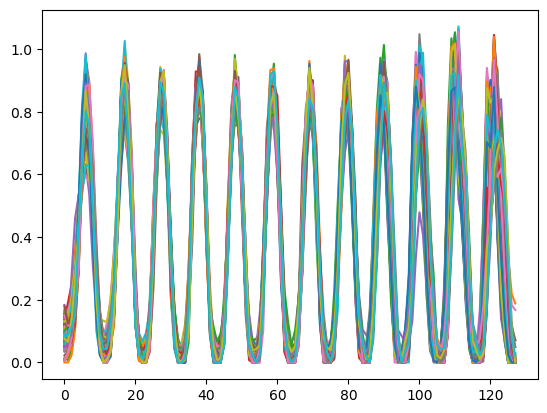

In [7]:
preds = model_nuc(X).detach().cpu().numpy().squeeze(axis=-1)
plt.plot(preds.T)
plt.show()

In [8]:
shap_values = SHAP.shap_values(X, check_additivity=False)
print(shap_values.shape)
np.savez(
    "generated/regnuc_2kb_100seq_randomflanks/shap_complete100_allheads", shap_values
)

(100, 2048, 4, 128)


In [10]:
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/shap_complete100_head64.npy",
    np.transpose(shap_values[..., 64], axes=[0, 2, 1]),
)
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/shap_complete100_head59.npy",
    np.transpose(shap_values[..., 59], axes=[0, 2, 1]),
)

In [9]:
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/shap_complete100_head43_53_64_75_85.npy",
    np.transpose(shap_values[..., [43, 53, 64, 75, 85]], axes=[0, 3, 2, 1]).reshape(
        -1, 4, 2048
    ),
)
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/shap_complete100_head38_48_59_70_80.npy",
    np.transpose(shap_values[..., [38, 48, 59, 70, 80]], axes=[0, 3, 2, 1]).reshape(
        -1, 4, 2048
    ),
)

In [59]:
lows = np.array(
    [
        11,
        12,
        21,
        22,
        23,
        31,
        32,
        33,
        34,
        41,
        42,
        43,
        44,
        45,
        52,
        53,
        54,
        55,
        62,
        63,
        64,
        65,
        73,
        74,
        75,
        76,
        84,
        85,
        86,
        94,
        95,
        96,
        97,
        104,
        105,
        106,
        107,
        115,
        116,
        117,
        126,
        127,
    ]
)
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/shap_first1_lowheads.npy",
    np.transpose(shap_values[:1, ..., lows], axes=[0, 3, 2, 1]).reshape(-1, 4, 2048),
)

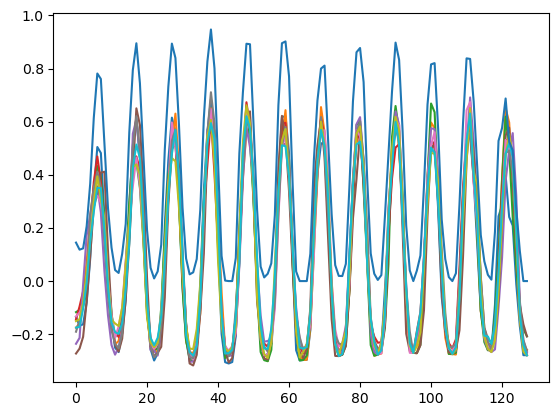

In [18]:
shap_sum = np.sum(shap_values, axis=(1, 2))
plt.plot(shap_sum.T, label="shap_sum")
plt.plot(preds[:1].T, label="pred")

In [11]:
X_numpy = X.detach().cpu().numpy()
X_numpy.shape

(100, 2048, 4)

In [12]:
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/ohe_complete100.npy",
    np.transpose(X_numpy, axes=[0, 2, 1]),
)
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/ohe_complete100_times5.npy",
    np.repeat(np.transpose(X_numpy, axes=[0, 2, 1]), 5, axis=0),
)

In [61]:
np.save(
    "generated/regnuc_2kb_100seq_randomflanks/ohe_first1_times42.npy",
    np.repeat(np.transpose(X_numpy[:1], axes=[0, 2, 1]), 42, axis=0),
)

In [14]:
import h5py

In [42]:
with h5py.File(
    "generated/regnuc_2kb_100seq_randomflanks/modisco_results_shap_complete100_head38_48_59_70_80.h5"
) as f:
    print(list(f["pos_patterns"]["pattern_0"].keys()))
    print(list(f["pos_patterns"]["pattern_0"]["seqlets"].keys()))
    pos_patterns = f["pos_patterns"]
    for pattern_id, pattern in pos_patterns.items():
        seqlets = pattern["seqlets"]
        print(
            pattern_id,
            seqlets["n_seqlets"][0],
            sorted(np.array(seqlets["example_idx"])),
        )
        for subid, subelement in pattern.items():
            if subid.startswith("subpattern"):
                subseqlets = subelement["seqlets"]
                print(
                    "\t",
                    subid,
                    subseqlets["n_seqlets"][0],
                    sorted(np.array(subseqlets["example_idx"])),
                )

['contrib_scores', 'hypothetical_contribs', 'seqlets', 'sequence', 'subpattern_0', 'subpattern_1', 'subpattern_2', 'subpattern_3', 'subpattern_4', 'subpattern_5', 'subpattern_6']
['contrib_scores', 'end', 'example_idx', 'hypothetical_contribs', 'is_revcomp', 'n_seqlets', 'sequence', 'start']
pattern_0 127 [2, 2, 7, 17, 17, 23, 32, 33, 38, 42, 42, 43, 48, 52, 53, 57, 58, 62, 67, 68, 72, 77, 82, 83, 97, 101, 102, 103, 107, 117, 122, 126, 127, 128, 137, 138, 142, 142, 147, 148, 152, 153, 157, 157, 162, 163, 166, 167, 168, 172, 179, 182, 183, 187, 192, 203, 217, 218, 228, 231, 232, 237, 237, 247, 252, 258, 262, 262, 267, 268, 277, 282, 288, 297, 298, 302, 306, 307, 308, 312, 317, 322, 326, 327, 327, 328, 332, 337, 338, 342, 346, 347, 353, 357, 367, 368, 373, 377, 382, 383, 384, 388, 397, 397, 398, 402, 403, 407, 407, 412, 417, 417, 427, 433, 437, 442, 453, 462, 462, 472, 478, 482, 487, 492, 497, 497, 498]
	 subpattern_0 36 [7, 107, 127, 128, 147, 148, 157, 168, 172, 183, 218, 228, 237, 267

In [20]:
shap_proj = shap_values[X_numpy.astype(bool)[:1]]
shap_proj.shape

(2048, 128)

<Axes: >

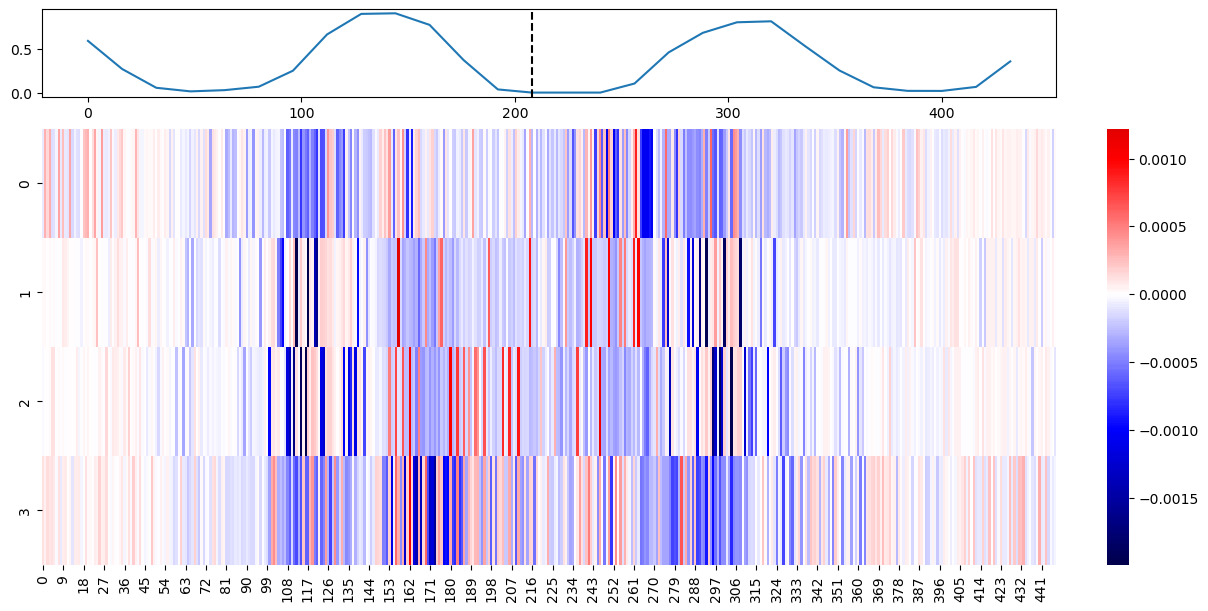

In [22]:
start = 800
stop = 1248
head_idx = 63
fig, axes = plt.subplots(
    2,
    1,
    figsize=(12, 6),
    facecolor="w",
    layout="constrained",
    sharex="row",
    gridspec_kw={"height_ratios": [1, 5]},
)
axes[0].plot(
    np.arange(start % 16, stop - start, 16), preds[0, start // 16 : stop // 16]
)
axes[0].axvline(x=head_idx * 16 - start, color="k", linestyle="--")
sns.heatmap(
    shap_values[0, start:stop, :, head_idx].T, cmap="seismic", center=0, ax=axes[1]
)

In [30]:
def local_max(values, winsize=2):
    local_max_list = []
    for i in range(winsize, len(values) - winsize):
        if np.all(values[i] >= values[np.arange(i - winsize, i + winsize + 1)]):
            local_max_list.append(i)
    return np.array(local_max_list)

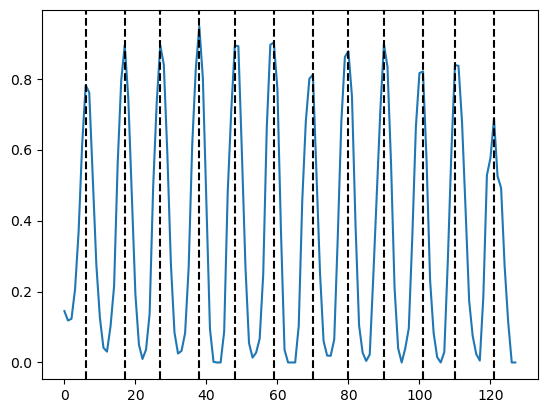

In [42]:
local_max_list = local_max(preds[0])
plt.plot(preds[0])
for locmax in local_max_list:
    plt.axvline(locmax, color="k", linestyle="--")
# np.unique(local_max, return_counts=True)

In [58]:
np.where(preds[0] < 0.1)[0]

array([ 11,  12,  21,  22,  23,  31,  32,  33,  34,  41,  42,  43,  44,
        45,  52,  53,  54,  55,  62,  63,  64,  65,  73,  74,  75,  76,
        84,  85,  86,  94,  95,  96,  97, 104, 105, 106, 107, 115, 116,
       117, 126, 127])

In [43]:
local_max_list

array([  6,  17,  27,  38,  48,  59,  70,  80,  90, 101, 110, 121])

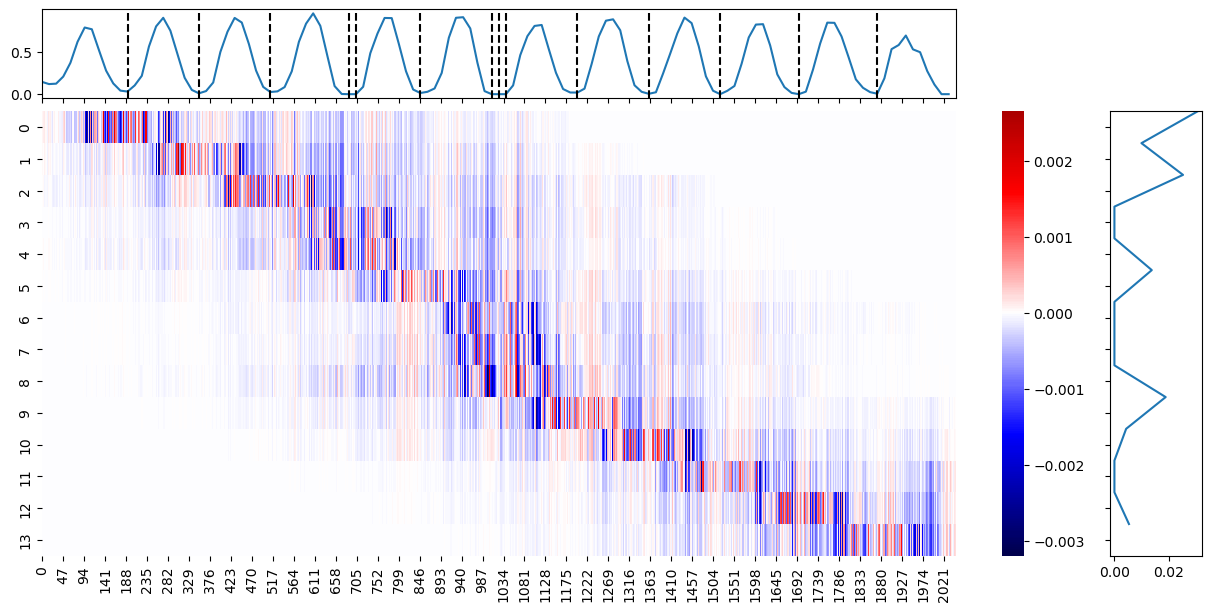

In [ ]:
start = 0
stop = 2048
head_indices = local_max(-preds)  # np.arange(50, 78)
fig, axes = plt.subplots(
    2,
    2,
    figsize=(12, 6),
    facecolor="w",
    layout="constrained",
    sharex="col",
    sharey="row",
    gridspec_kw={"height_ratios": [1, 5], "width_ratios": [10, 1]},
)
axes[0, 0].plot(
    np.arange(start % 16, stop - start, 16), preds[start // 16 : stop // 16]
)
for head_idx in head_indices:
    axes[0, 0].axvline(x=head_idx * 16 - start, color="k", linestyle="--")
sns.heatmap(
    shap_proj[start:stop, head_indices].T, cmap="seismic", center=0, ax=axes[1, 0]
)
axes[1, 1].plot(preds[head_indices], np.arange(len(head_indices)))
axes[0, 1].set_axis_off()

In [2]:
with pyBigWig.open(
    "/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.bw"
) as bw:
    chrom_sizes = bw.chroms()
for chrom in chrom_sizes:
    with np.load(
        f"shap/shap_model_myco_nuc_pt8_on_W303_Mmmyco_mid_{chrom}_for_16.npz"
    ) as f:
        res = f["res"]
        positions = f["positions"]
    break

In [3]:
res.shape, positions.shape

((239, 2048, 4, 128), (239,))

In [4]:
seq_dict = utils.ordinal_encoder(
    {
        seq.id: str(seq.seq)
        for seq in SeqIO.parse(
            "/home/alex/shared_folder/SCerevisiae/genome/W303_Mmmyco.fa", format="fasta"
        )
    }
)
one_hot = utils.idx_to_onehot(seq_dict[chrom])

In [5]:
sumabs = (
    np.abs(
        res
        * np.expand_dims(
            one_hot[(positions.reshape(-1, 1) + np.arange(2048).reshape(1, -1))],
            axis=-1,
        )
    )[..., 32:96]
    .sum(axis=2)
    .sum(axis=2)
)
sumabs.shape

(239, 2048)

In [6]:
aligned_sumabs = np.zeros(chrom_sizes[chrom])
for i, pos in enumerate(positions):
    aligned_sumabs[pos : pos + 2048] += sumabs[i]
aligned_sumabs /= 2
aligned_sumabs.shape

(245675,)

In [7]:
with pyBigWig.open(
    "Trainedmodels/model_myco_nuc_pt8/preds_model_myco_nuc_pt8_on_W303_Mmmyco_mid_track0.bw"
) as bw:
    preds = bw.values(f"{chrom}_for", 0, -1, numpy=True)
with np.load("/home/alex/shared_folder/SCerevisiae/data/labels_myco_nuc.npz") as f:
    labels = f[chrom]
with np.load(
    "/home/alex/shared_folder/SCerevisiae/results/model_myco_nuc_2/saliency_model_myco_nuc_2_W303_Mmmyco_onseq_sumabs.npz"
) as f:
    saliency_ref = f[chrom]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


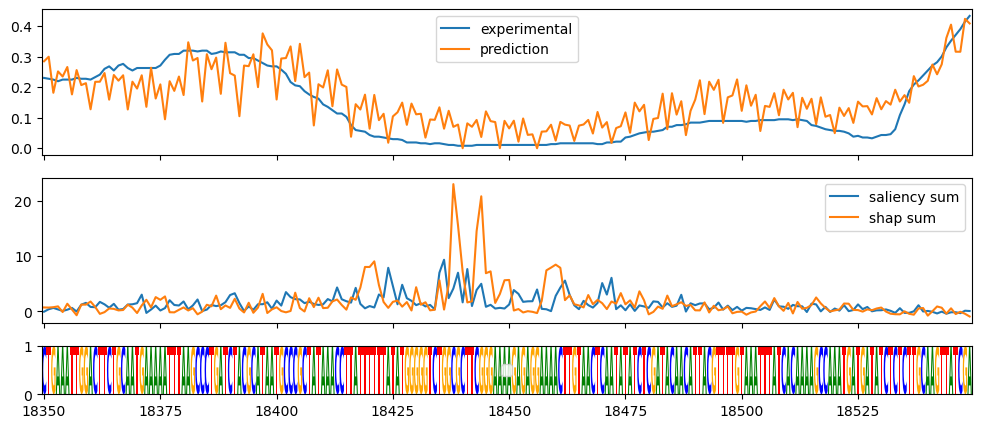

In [8]:
start = 18350
stop = start + 200
fig, axes = plt.subplots(3, 1, figsize=(12, 5), facecolor="w", sharex=True, gridspec_kw={"height_ratios": [3, 3, 1]})
axes[0].plot(np.arange(start, stop), labels[start:stop], label="experimental")
axes[0].plot(np.arange(start, stop), preds[start:stop], label="prediction")
axes[1].plot(
    np.arange(start, stop), utils.z_score(saliency_ref)[start:stop], label="saliency sum"
)
axes[1].plot(
    np.arange(start, stop), utils.z_score(aligned_sumabs)[start:stop], label="shap sum"
)
if stop - start < 1000:
    lm.Logo(
        pd.DataFrame(
            one_hot[start:stop], columns=list("ACGT"), index=np.arange(start, stop)
        ),
        ax=axes[2],
    )
for ax in axes:
    ax.legend()

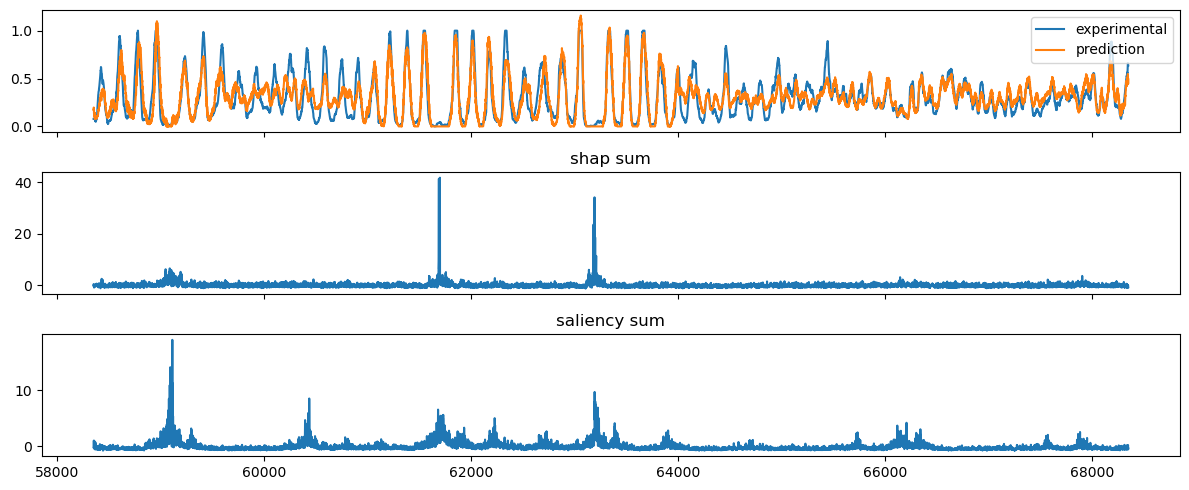

In [12]:
start = 58350
stop = start + 10000
fig, axes = plt.subplots(3, 1, figsize=(12, 5), facecolor="w", layout='tight', sharex=True)
axes[0].plot(np.arange(start, stop), labels[start:stop], label="experimental")
axes[0].plot(np.arange(start, stop), preds[start:stop], label="prediction")
axes[0].legend()
axes[1].set_title("shap sum")
axes[2].set_title("saliency sum")
if stop - start < 1000:
    lm.Logo(
        pd.DataFrame(
            one_hot[start:stop]*utils.z_score(aligned_sumabs)[start:stop, None], columns=list("ACGT"), index=np.arange(start, stop)
        ),
        ax=axes[1],
    )
    lm.Logo(
        pd.DataFrame(
            one_hot[start:stop]*utils.z_score(saliency_ref)[start:stop, None], columns=list("ACGT"), index=np.arange(start, stop)
        ),
        ax=axes[2],
    )
else:
    axes[1].plot(
        np.arange(start, stop), utils.z_score(aligned_sumabs)[start:stop]
    )
    axes[2].plot(
        np.arange(start, stop), utils.z_score(saliency_ref)[start:stop]
    )